In [121]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re

import urllib

from scipy import stats

</div>
<div class="1. Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white;">
       <h2>1. Data</h2>
        <h4>In this first section we import and rearrange the data.</h4>
    </span>
</div>
</div>

</div>
<div class="1.1 Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.1 Data acquisition</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Here we load the relevant data using the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">pd.read_csv()</span> method. The data we are dealing with follows a relational model. The specific navigation paths can be represented as graphs where the nodes concern the wikipedia pages that are connected through (directional) edges representing the hyperlinks.
    </span>
</div>

In [122]:
#Import relevant DataFrames

#Articles data
articles = pd.read_csv("data/articles.tsv", skiprows=11, names=["article"])
articles['article'] = articles['article'].apply(urllib.parse.unquote) #Parsing URL encoding

#Category data
categories = pd.read_csv("data/categories.tsv", sep="\t", skiprows=12, names=["article", "category"])
categories["article"] = categories["article"].apply(urllib.parse.unquote) #Parsing URL encoding

#Links data
links = pd.read_csv("data/links.tsv", sep="\t", skiprows=11, names=["article", "link"])
links["article"] = links["article"].apply(urllib.parse.unquote) #Parsing URL encoding
links["link"] = links["link"].apply(urllib.parse.unquote) #Parsing URL encoding

#Finished paths
paths_finished = pd.read_csv("data/paths_finished.tsv", sep="\t", skiprows=15, names=["hashedIpAddress",
                                                                                      "timestamp",
                                                                                      "durationInSec",
                                                                                      "path",
                                                                                      "rating"])
paths_finished["path"] = paths_finished["path"].apply(urllib.parse.unquote) #Parsing URL encoding

#Unfinished paths
paths_unfinished = pd.read_csv("data/paths_unfinished.tsv", sep="\t", skiprows=16, names=["hashedIpAddress",
                                                                                          "timestamp",
                                                                                          "durationInSec",
                                                                                          "path",
                                                                                          "target",
                                                                                          "type"])
paths_unfinished["path"] = paths_unfinished["path"].apply(urllib.parse.unquote) #Parsing URL encoding
paths_unfinished["target"] = paths_unfinished["target"].apply(urllib.parse.unquote) #Parsing URL encoding

# Add the length of the paths
paths_unfinished['pathLength'] = paths_unfinished['path'].apply(lambda x : len(str(x).split(';')))
paths_finished['pathLength'] = paths_finished['path'].apply(lambda x : len(str(x).split(';')))

#shortest path matrix
with open('data/shortest-path-distance-matrix.txt', 'r') as file:
    
    #Initialize shortest_path_distance list
    shortest_path_distance = []
    
    for line in file:
        
        #Check if the first character of the line is either a digit or underscore
        if re.search("([0-9]|_)", line[0]): 
            
            #Append list to shortest_path_distance
            shortest_path_distance.append([np.nan if x=='_' else int(x) for x in line.strip()])
    
#Convert to numpy ndarray
shortest_path_distance = np.array(shortest_path_distance) 

</div>
<div class="1.2 Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.2 Data concatenation</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We want to merge both the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_finished</span> and <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_unfinished</span> DataFrame. This make the analysis more convenient when comparing both types. More specifically we add the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">target</span> column to and drop the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">rating </span> column of <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">paths_finished</span>. We can then concatenate the respective DataFrames together. 
</div>

In [123]:
#Merge all the paths 
paths_finished['target'] = paths_finished['path'].apply(lambda x : str(x).split(';')[-1])

#Add and remove (ir)relevant colums.
paths_finished_ = paths_finished.copy()
paths_unfinished_ = paths_unfinished.copy()
paths_finished_['type'] = 'finished'
paths_finished_ = paths_finished_.drop('rating',axis =1)

#concatenate data
paths_all = pd.concat([paths_finished_, paths_unfinished_]) 

#print head of resulting DataFrame
paths_all.head(4)

,hashedIpAddress,timestamp,durationInSec,path,pathLength,target,type
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,9,African_slave_trade,finished
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,5,African_slave_trade,finished
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,8,African_slave_trade,finished
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,4,Greece,finished


</div>
<div class="4. Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white;">
       <h2>1. Between game analysis</h2>
        <h4>Here we will focus on the level of an individual player and the history of the different Wikispeedia games (i.e. between game) that have been played by that person consecutively.</h4>
    </span>
</div>
</div>

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.1 Game distribution per player</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We can globally categorize the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">between_game</span> game history (chronologically) in 3 groups:
        <ul>
            <li> <code class='python'>finished</code>: The player's last game was a <code class='python'>finished</code> path (e.g. <code class='python'>[timeout, restart, finished]</code>)</li>
            <li> <code class='python'>timeout</code>: The player's last game was a <code class='python'>finished</code> timeout (e.g. <code class='python'>[timeout, restart, timeout]</code>)</li>
            <li> <code class='python'>restart</code>: The player's last game was a <code class='python'>finished</code> restart (e.g. <code class='python'>[timeout, restart, restart]</code>)</li>
        </ul>
        Per category, we want to find and display the distribution for the number of succesfully <code class='python'>finished</code> games. Firsts we need to extract the  <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">between_game</span> history per player. From that, we can extract the <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">last_game</span> and <span style="font-family: monospace; background-color:#fadfb9; padding-left:4px; padding-right:4px; border-radius: 5px;">nb_finished_games</span> columns
    </span>
</div>


In [124]:
#Create DataFrame with chronological (between_game) history of games player
players_record = pd.DataFrame(paths_all.sort_values('timestamp').groupby('hashedIpAddress')['type'].apply(list))
players_record = players_record.rename(columns={'type': 'between_game'})

#Display snipped of result
players_record.head(4)

,between_game
hashedIpAddress,
000386124f307de8,"[finished, timeout]"
0007183207b6008f,"[finished, finished, finished]"
000a09e202e88d10,[finished]
000a5bac5b7781ea,[finished]


In [125]:
#Now extract last_game column
players_record['last_game'] = players_record['between_game'].apply(lambda l : l[-1])

#Now extract nb_finished_games, nb_restart_games and nb_timeout_games and nb_total_games column
players_record['nb_finished_games'] = players_record['between_game'].apply(lambda x: x.count('finished'))
players_record['nb_restart_games'] = players_record['between_game'].apply(lambda x: x.count('restart'))
players_record['nb_timeout_games'] = players_record['between_game'].apply(lambda x: x.count('timeout'))
players_record['nb_total_games'] = players_record['between_game'].apply(lambda x: len(x))

#Display snipped of results
players_record.head(10)

,between_game,last_game,nb_finished_games,nb_restart_games,nb_timeout_games,nb_total_games
hashedIpAddress,,,,,,
000386124f307de8,"[finished, timeout]",timeout,1,0,1,2
0007183207b6008f,"[finished, finished, finished]",finished,3,0,0,3
000a09e202e88d10,[finished],finished,1,0,0,1
000a5bac5b7781ea,[finished],finished,1,0,0,1
000a6e585b776c96,[timeout],timeout,0,0,1,1
000bc9fe5640ed31,"[finished, finished]",finished,2,0,0,2
000d397013f09039,"[finished, finished]",finished,2,0,0,2
000e5d4c2c8e921f,"[finished, restart, restart, timeout]",timeout,1,2,1,4
000e954305ddb434,[finished],finished,1,0,0,1


</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.2 Data processing game distribution per player</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        There are some players that played several thousand times. The question is if they will be taken into account? Maximum ist at 4'685 so very high. Til what number should we take them into account? What is reasonable?
       Mels do you have an idea what Treshold to set or if we have to analyze it? For the restart and the timeout in the last, the distributions are more similar
    </span>
</div>


In [126]:
test =players_record[players_record['last_game']== 'finished']

In [127]:
players_record[players_record['nb_finished_games'] > 100].head(10)

,between_game,last_game,nb_finished_games,nb_restart_games,nb_timeout_games,nb_total_games
hashedIpAddress,,,,,,
0299542414c3f20a,"[finished, finished, finished, finished, finis...",finished,172,0,0,172
0d57c8c57d75e2f5,"[finished, finished, finished, finished, finis...",finished,4865,0,0,4865
101779c07d4d00f0,"[finished, finished, finished, finished, finis...",finished,139,0,0,139
26f76e394525328e,"[restart, restart, finished, finished, restart...",timeout,107,146,17,270
321e4b101c5b58ff,"[finished, finished, finished, finished, finis...",finished,196,0,0,196
473d6ac602c2b198,"[finished, finished, finished, finished, finis...",finished,545,56,36,637
5590014e126275b4,"[finished, finished, finished, finished, finis...",finished,110,0,0,110
58f1667d434c79f1,"[finished, finished, finished, finished, finis...",finished,118,0,0,118
5bb5836b425e6bfe,"[timeout, finished, finished, finished, finish...",restart,243,41,24,308


In [128]:
players_record[players_record['nb_restart_games'] > 100].head(10)

,between_game,last_game,nb_finished_games,nb_restart_games,nb_timeout_games,nb_total_games
hashedIpAddress,,,,,,
26f76e394525328e,"[restart, restart, finished, finished, restart...",timeout,107,146,17,270
75bd20c663d02c8f,"[restart, restart, restart, finished, restart,...",restart,145,119,33,297


Distribution of the finished paths. Can show the same for the other distributions, just change the test dataframe below

In [129]:
test =players_record[players_record['last_game']== 'timeout']

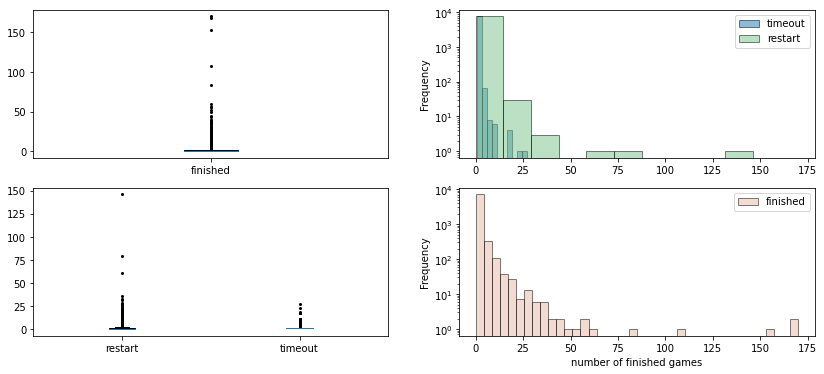

In [130]:
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(2,2,1)
ax.boxplot(test['nb_finished_games'], patch_artist=True, flierprops=flierprops, boxprops=boxprops, medianprops=medianprops, labels=['finished']);
xlim = ax.get_xlim();

ax = plt.subplot(2,2,3)
ax.boxplot([test['nb_restart_games'], test['nb_timeout_games']], patch_artist=True, flierprops=flierprops, boxprops=boxprops, medianprops=medianprops, labels=['restart','timeout'])
xlim = ax.get_xlim();


ax = plt.subplot(2,2,4)
test.plot(y='nb_finished_games', kind='hist', legend=False, edgecolor=(0,0,0, 0.5), bins=40, ax=ax, log=True, color=(235/255, 184/255, 164/255, 0.5), label="finished")
ax.legend();
ax.set_xlabel('number of finished games')
xlim = ax.get_xlim();

ax = plt.subplot(2,2,2)
test.plot(y='nb_timeout_games', kind='hist', legend=False, edgecolor=(0,0,0, 0.5), ax=ax, log=True, color=(31/255, 119/255, 180/255, 0.5), label="timeout")
test.plot(y='nb_restart_games', kind='hist', legend=False, edgecolor=(0,0,0, 0.5), ax=ax, log=True, color=(120/255, 194/255, 139/255, 0.5), label="restart")
ax.legend();
ax.set_xlim(xlim);

In [131]:
test['nb_finished_games'].describe()

count    7654.000000
mean        1.285733
std         4.922636
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       170.000000
Name: nb_finished_games, dtype: float64

In [132]:
test['nb_restart_games'].describe()

count    7654.000000
mean        0.933499
std         2.933987
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       146.000000
Name: nb_restart_games, dtype: float64

In [133]:
test['nb_timeout_games'].describe()

count    7654.000000
mean        1.131043
std         0.779118
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        27.000000
Name: nb_timeout_games, dtype: float64

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.3 Calculate percentage of people that had restart/timeout/finished path before the final part for every possible outcome</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        What data do we want to include? When someone did a timeout and comes bad, do we take them into account? Or do we have to filter them out?
    </span>
</div>


In [134]:
timeout = players_record[players_record['last_game']== 'timeout']
percentage_finished = len(timeout[timeout['nb_finished_games']> 0])/len(timeout)
percentage_restart = len(timeout[timeout['nb_restart_games']> 0])/len(timeout)
percentage_timeout = len(timeout[timeout['nb_timeout_games']> 1])/len(timeout)
print('Percentage of users that finished a path before a timeout: ',percentage_finished)
print('Percentage of users that restarted a path before a timeout: ',percentage_restart)
print('Percentage of users that had a timeout before the final timeout: ',percentage_timeout)

Percentage of users that finished a path before a timeout:  0.3424353279331069
Percentage of users that restarted a path before a timeout:  0.36007316435850534
Percentage of users that had a timeout before the final timeout:  0.06924483929971256


In [135]:
restart = players_record[players_record['last_game']== 'restart']
percentage_finished = len(restart[restart['nb_finished_games']> 0])/len(restart)
percentage_timeout = len(restart[restart['nb_timeout_games']> 0])/len(restart)
percentage_restart = len(restart[restart['nb_restart_games']> 1])/len(restart)
print('Percentage of users that finished a path before the end restart: ',percentage_finished)
print('Percentage of users that did a timeout of a path before the end restart: ',percentage_timeout)
print('Percentage of users that had a restart before the final restart: ',percentage_restart)

Percentage of users that finished a path before the end restart:  0.28216704288939054
Percentage of users that did a timeout of a path before the end restart:  0.042437923250564336
Percentage of users that had a restart before the final restart:  0.3110609480812641


In [136]:
finished = players_record[players_record['last_game']== 'finished']
percentage_restart = len(finished[finished['nb_restart_games']> 0])/len(finished)
percentage_timeout = len(finished[finished['nb_timeout_games']> 0])/len(finished)
percentage_finished = len(finished[finished['nb_finished_games']> 1])/len(finished)
print('Percentage of users that restarted a path before the finished path: ',percentage_restart)
print('Percentage of users that did a timeout of a path before the finished path: ',percentage_timeout)
print('Percentage of users that had a finished path before the final finished path: ',percentage_finished)

Percentage of users that restarted a path before the finished path:  0.14229859974540826
Percentage of users that did a timeout of a path before the finished path:  0.021185670121840333
Percentage of users that had a finished path before the final finished path:  0.4891798508819785


</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.4 General preprocessing of data</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
       takes out everything that has zero pathlength -> can I do on monday
    </span>
</div>
